In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import string
from nltk.tokenize import word_tokenize
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
with open('bleak.txt', 'rt') as f:
    content = f.read()
print(content[:100])

﻿The Project Gutenberg eBook, Bleak House, by Charles Dickens


This eBook is for the use of anyone 


In [4]:

content = content.translate(str.maketrans('', '', string.punctuation))

In [5]:

words = word_tokenize(content)

In [6]:
words[:10]

['\ufeffThe',
 'Project',
 'Gutenberg',
 'eBook',
 'Bleak',
 'House',
 'by',
 'Charles',
 'Dickens',
 'This']

In [7]:
most_common_count = 2000
c = Counter(words)
most_common = [pair[0] for pair in c.most_common(most_common_count)]
words_with_unk = [word if word in most_common else '<UNK>' for word in words]
words_with_unk[:10]

['<UNK>',
 'Project',
 'Gutenberg',
 '<UNK>',
 'Bleak',
 'House',
 'by',
 '<UNK>',
 '<UNK>',
 'This']

In [8]:
context_size = 2
input = []
for a in range(context_size, len(words_with_unk)-context_size):
    x = [item for sublist in [words_with_unk[a-context_size:a], words_with_unk[a+1:a+context_size+1], [words_with_unk[a]]] for item in sublist]
    input.append(x)

In [9]:
input[:5]

[['<UNK>', 'Project', '<UNK>', 'Bleak', 'Gutenberg'],
 ['Project', 'Gutenberg', 'Bleak', 'House', '<UNK>'],
 ['Gutenberg', '<UNK>', 'House', 'by', 'Bleak'],
 ['<UNK>', 'Bleak', 'by', '<UNK>', 'House'],
 ['Bleak', 'House', '<UNK>', '<UNK>', 'by']]

In [10]:
len(input), len(words_with_unk)

(356557, 356561)

In [11]:
vocab = set(words_with_unk); len(vocab)

2001

In [12]:
'<UNK>' in vocab

True

In [28]:
index_to_word = {k:v for k, v in enumerate(vocab)}
gen = (item for item in index_to_word.items())
[next(gen) for _ in range(5)]

[(0, 'pavement'), (1, 'kiss'), (2, 'done'), (3, 'husband'), (4, 'take')]

In [37]:
word_to_index = {v:k for k, v in index_to_word.items()}; 
gen2 = (item for item in word_to_index.items())
[next(gen2) for _ in range(5)]

[('pavement', 0), ('kiss', 1), ('done', 2), ('husband', 3), ('take', 4)]

In [38]:

def word_to_vec(word):
    vec = np.zeros(len(vocab))
    if word in word_to_index.keys():
        vec[word_to_index[word]] = 1
    else:
        vec[word_to_index['<UNK>']] = 1
    return vec
word_to_one_hot = {}
for word in vocab:
    word_to_one_hot[word] = word_to_vec(word)

In [39]:
list(word_to_one_hot.items())[:5]

[('pavement', array([1., 0., 0., ..., 0., 0., 0.])),
 ('kiss', array([0., 1., 0., ..., 0., 0., 0.])),
 ('done', array([0., 0., 1., ..., 0., 0., 0.])),
 ('husband', array([0., 0., 0., ..., 0., 0., 0.])),
 ('take', array([0., 0., 0., ..., 0., 0., 0.]))]

In [40]:
Xs = []
Ys = []
for row in input:
    x = np.vstack([word_to_one_hot[word] for word in row[:-1]]).mean(axis=0)
    Xs.append(x)
    y = [word_to_one_hot[word] for word in row[-1:]]
    Ys.append(y)
    
X = np.vstack(Xs)
Y = np.vstack(Ys)

In [43]:
X.shape, Y.shape

((356557, 2001), (356557, 2001))

In [44]:
np.set_printoptions(threshold=1002)
np.argmax(Y[0])

800

In [45]:

X = csr_matrix(X)
Y = csr_matrix(Y)

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [48]:
model = keras.Sequential()
model.add(keras.Input(shape=(X_train.shape[1],)))
model.add(layers.Dense(2000, activation='relu', name='layer-1'))
model.add(layers.Dense(len(vocab), activation='softmax', name='output-layer'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer-1 (Dense)              (None, 2000)              4004000   
_________________________________________________________________
output-layer (Dense)         (None, 2001)              4004001   
Total params: 8,008,001
Trainable params: 8,008,001
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.CategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.CategoricalAccuracy()],
)

In [53]:
model.fit(X_train.toarray(), Y_train.toarray(), batch_size=256, epochs=10)

Train on 267417 samples
Epoch 1/10
267417/267417 [==============================] - 91s 340us/sample - loss: 4.7552 - categorical_accuracy: 0.1980
Epoch 2/10
267417/267417 [==============================] - 91s 338us/sample - loss: 4.5428 - categorical_accuracy: 0.2162
Epoch 3/10
267417/267417 [==============================] - 87s 325us/sample - loss: 4.3876 - categorical_accuracy: 0.2310
Epoch 4/10
267417/267417 [==============================] - 86s 321us/sample - loss: 4.2590 - categorical_accuracy: 0.2443
Epoch 5/10
267417/267417 [==============================] - 89s 333us/sample - loss: 4.1537 - categorical_accuracy: 0.2573
Epoch 6/10
267417/267417 [==============================] - 95s 356us/sample - loss: 4.0591 - categorical_accuracy: 0.2695
Epoch 7/10
267417/267417 [==============================] - 91s 340us/sample - loss: 3.9696 - categorical_accuracy: 0.2824
Epoch 8/10
267417/267417 [==============================] - 86s 321us/sample - loss: 3.8858 - categorical_accuracy:

In [54]:
model.save('saved_model/first_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/first_model/assets


In [3]:
new_model = tf.keras.models.load_model('saved_model/first_model')

In [175]:
new_model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

x y
[0] [3]
[1] [5]
[2] [7]
[3] [9]
[4] [11]
[5] [13]
[6] [15]
[7] [17]
[8] [19]
[9] [21]


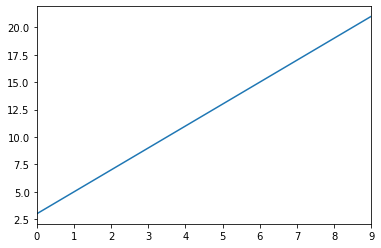

In [176]:
# Simple linear model

# y = 2x + 3

x = []
y = []

for index in range(10):
    x.append(index)
    y.append(index*2+3)

x = np.array(x).reshape(-1,1)
y = np.array(y).reshape(-1,1)

print('x', 'y')
for a, b in zip(x, y):
    print(a, b)

plt.plot(x, y)
plt.xlim([0,max(x)])
plt.show()

In [177]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [178]:
model = tf.keras.Sequential()
model.add(layers.Dense(100, input_dim=x_train.shape[1], activation='relu'))
model.add(layers.Dense(1))
opt = tf.keras.optimizers.Adam(learning_rate=.01)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 101       
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [179]:
history = model.fit(x_train, y_train, epochs=50, verbose=0)
model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 118ms/sample - loss: 0.2775 - mean_squared_error: 0.2775


[0.2775091826915741, 0.27750918]

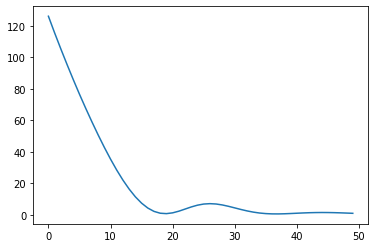

In [180]:
plt.plot(history.history['loss'])

In [169]:
model.predict([5])

array([[12.124927]], dtype=float32)

In [170]:
model.save('saved_model/first_model')

INFO:tensorflow:Assets written to: saved_model/first_model/assets


In [171]:
model = tf.keras.models.load_model('saved_model/first_model')

In [172]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 101       
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [173]:
model.predict([5])

array([[12.124927]], dtype=float32)

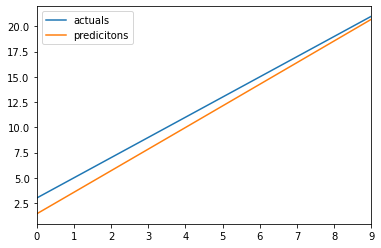

In [174]:
plt.plot(x, y, label='actuals')
plt.plot(model.predict(x), label='predicitons')
plt.xlim([0,max(x)])
plt.legend()
plt.show()

In [126]:
model.predict(x)

array([[ 2.8924086],
       [ 4.937794 ],
       [ 6.9752073],
       [ 8.982738 ],
       [10.987984 ],
       [12.993218 ],
       [14.998453 ],
       [17.003687 ],
       [19.008928 ],
       [21.014175 ]], dtype=float32)

In [127]:
y

array([[ 3],
       [ 5],
       [ 7],
       [ 9],
       [11],
       [13],
       [15],
       [17],
       [19],
       [21]])